In [ ]:
# numerical method library (array, linear algebra, matrices)
import numpy as np
# dataframe (sql)
import pandas as pd
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib 의 기본 scheme 이 아닌 seaborn scheme 을 세팅
# 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 사용하면 편리함
plt.style.use('seaborn')
sns.set(font_scale = 2.5)

import missingno as msno

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

**1. dataset 확인 - null data 등 확인, 수정**

In [ ]:
df_train = pd.read_csv('../input/titanic/train.csv')
df_test = pd.read_csv('../input/titanic/test.csv')

In [ ]:
df_train.head()

* 예측하려고 하는 target label : Survived
* Feature : Pclass, Age, SibSp, Parch, Fare

* 변수(feature, variable)
* survival 생존여부 : target label / 1, 0 으로 표현 (integer)
* Pclass 티켓의 클래스 : 1 = 1st, 2 = 2nd, 3 = 3rd 클래스로 나뉨, categorical feature (integer)
* sex 성별 : male, female 로 구분, binary (string)
* Age 나이 : continuous (integer)
* sibSp 함께 탑승한 형제와 배우자의 수 : discrete (integer)
* parch 함께 탑승한 부모, 아이의 수 : discrete (integer)
* ticket 티켓 번호 : alphabat + integer (string)
* fare 탑승료 : continuous (float)
* cabin 객실 번호 : alphabat + integer (string)
* embared 탑승 항구 : C = Cherbourg, Q = Queenstown, S = Southampton (string)

pandas dataframe 의 describe() method : 각 feature 가 가진 통계치 반환

In [ ]:
df_train.describe()

In [ ]:
df_test.describe()

PassengerID 숫자와 다른, null data 가 존재하는 열이 있는 것으로 보임

**1.1 Null data check**

In [ ]:
for col in df_train.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_train[col].isnull().sum() / df_train[col].shape[0]))
    print(msg)

df_train[col].isnull().sum() 을 통해서 isnull() 이 true 라면 1의 값을 가지기 때문에 isnull() 의 합을 
df_train의 행 차원의 값을 반환하는 df_train[col].shape[0] 으로 나누어주어 null 값을 가진 feature 가 있는지 확인할 수 있음

In [ ]:
for col in df_test.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_test[col].isnull().sum() / df_test[col].shape[0]))
    print(msg)

In [ ]:
msno.matrix(df=df_train.iloc[:, :], figsize=(8, 8))

df_train 의 처음부터 끝까지의 열을 전부 불러와서 matrix로 만들어줌
빈칸은 null 값임

null data 가 어디에 분포하는지 확인에 용이함

In [ ]:
msno.bar(df=df_train.iloc[:, :], figsize=(8, 8))

null data 가 몇 퍼센트 존재하는지 그래프로 확인 가능

In [ ]:
# 1행 2열의 2가지 표 그릴 수 있는 종이 준비
f, ax = plt.subplots(1, 2, figsize=(18, 8))

# pie plot
# df_train['Survived'].value_counts() 를 통해 survived 가 몇 명인지 알 수 있음
# plot.pie() 를 통해 원형 그래프를 그림, explode 로 부분들을 나눔
# autopct = '%1.1f%%' 로 그래프 안에 각 부분이 몇 퍼센트를 차지하는지 보여줌 (소수점 1자리까지)
# ax = ax[0] 로 1행 1열에 plot 그림
df_train['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0])
ax[0].set_title('Pie plot - Survived')
ax[0].set_ylabel('')

# count plot
sns.countplot('Survived', data=df_train, ax=ax[1])
ax[1].set_title('Count plot - Survived')

plt.show()

38.4% 의 사람들이 생존했음을 알 수 있음

imbalanced 함

**2.1 Pclass**

In [ ]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).count()

In [ ]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).sum()

In [ ]:
pd.crosstab(df_train['Pclass'], df_train['Survived'], margins=True)

In [ ]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar()

In [ ]:
y_position = 1.02
f, ax = plt.subplots(1, 2, figsize=(18, 8))
df_train['Pclass'].value_counts().plot.bar(ax=ax[0])
ax[0].set_title('Number of Passengers By Pclass', y=y_position)
ax[0].set_ylabel('Count')
sns.countplot('Pclass', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Pclass: Survived vs Dead', y=y_position)
plt.show()

Pclass 가 높을수록 생존률도 높은것을 알수있음

**2.2 Sex**

In [ ]:
f, ax = plt.subplots(1, 2, figsize = (18, 8))
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index = True).mean().plot.bar(ax = ax[0])
ax[0].set_title('Survived by Sex')
sns.countplot('Sex', hue = 'Survived', data = df_train, ax = ax[1])
ax[1].set_title('Sex : Survived vs Dead')
plt.show()

여성이 남성보다 생존률이 높은 것을 알 수 있음

**2.2.1 Both Sex and Pclass**

In [ ]:
sns.factorplot('Pclass', 'Survived', hue = 'Sex', data = df_train, size = 6, aspect = 1.5)

In [ ]:
sns.factorplot(x = 'Sex', y = 'Survived', hue = 'Pclass', data = df_train, saturation = 5, size = 9, aspect = 1)

**2.3 Age**

In [ ]:
print('제일 나이가 많은 탑승객 : {:.1f} years'.format(df_train['Age'].max()))
print('제일 어린 탑승객 : {:.1f} years'.format(df_train['Age'].min()))
print('탑승객 평균 나이 : {:.1f} years'.format(df_train['Age'].mean()))

In [ ]:
# Kernel Distribution Estimation Plot (확률 밀도 함수)
# depicts the probability density function of the continuous or non-parametric data variables

fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.kdeplot(df_train[df_train['Survived'] == 1]['Age'], ax=ax)
sns.kdeplot(df_train[df_train['Survived'] == 0]['Age'], ax=ax)
plt.legend(['Survived == 1', 'Survived == 0'])
plt.show()

In [ ]:
# Age distribution within classes

plt.figure(figsize=(8, 6))
df_train['Age'][df_train['Pclass'] == 1].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 2].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 3].plot(kind='kde')

plt.xlabel('Age')
plt.title('Age Distribution within classes')
plt.legend(['1st Class', '2nd Class', '3rd Class'])

In [ ]:
# Pclass 1 의 연령별 생존 / 비생존 분포

fig, ax = plt.subplots(1, 1, figsize = (9, 5))
sns.kdeplot(df_train[(df_train['Survived'] == 0) & (df_train['Pclass'] == 1)]['Age'], ax = ax)
sns.kdeplot(df_train[(df_train['Survived'] == 1) & (df_train['Pclass'] == 1)]['Age'], ax = ax)
plt.legend(['Survived == 1', 'Survived == 0'])
plt.title('1st class')
plt.show()

In [ ]:
# Pclass 2 의 연령별 생존 / 비생존 분포

fig, ax = plt.subplots(1, 1, figsize = (9, 5))
sns.kdeplot(df_train[(df_train['Survived'] == 0) & (df_train['Pclass'] == 2)]['Age'], ax = ax)
sns.kdeplot(df_train[(df_train['Survived'] == 1) & (df_train['Pclass'] == 2)]['Age'], ax = ax)
plt.legend(['Survived == 1', 'Survived == 0'])
plt.title('2nd class')
plt.show()

In [ ]:
# Pclass 3 의 연령별 생존 / 비생존 분포

fig, ax = plt.subplots(1, 1, figsize = (9, 5))
sns.kdeplot(df_train[(df_train['Survived'] == 0) & (df_train['Pclass'] == 3)]['Age'], ax = ax)
sns.kdeplot(df_train[(df_train['Survived'] == 1) & (df_train['Pclass'] == 3)]['Age'], ax = ax)
plt.legend(['Survived == 1', 'Survived == 0'])
plt.title('3rd class')
plt.show()

In [ ]:
# 나이범위를 넓혀가며 생존률이 어떻게 변하는지 살펴보기
cummulate_survival_ratio = []
for i in range(1, 80):
    # i 보다 작은 age 의 survived 한 사람들의 생존률
    # i 보다 작은 age 의 survived 한 사람들을 sum 시키고, 이를 사람들의 수로 나누기
    cummulate_survival_ratio.append(df_train[df_train['Age'] < i]['Survived'].sum() / len(df_train[df_train['Age'] < i]['Survived']))
    
plt.figure(figsize=(7, 7))
plt.plot(cummulate_survival_ratio)
plt.title('Survival rate change depending on range of Age', y=1.02)
plt.ylabel('Survival rate')
plt.xlabel('Range of Age(0 ~ x)')
plt.show()

나이가 어릴수록 생존률이 높음을 알 수 있음

**2.3.1 Pclass, Sex, Age**

In [ ]:
f,ax=plt.subplots(1,2,figsize=(18,8))

sns.violinplot("Pclass","Age", hue="Survived", data=df_train, scale='count', split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))

sns.violinplot("Sex","Age", hue="Survived", data=df_train, scale='count', split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))

plt.show()

**2.4 Embarked**

In [ ]:
f,ax=plt.subplots(2, 2, figsize=(20,15))

sns.countplot('Embarked', data=df_train, ax=ax[0,0])
ax[0,0].set_title('(1) No. Of Passengers Boarded')

sns.countplot('Embarked', hue='Sex', data=df_train, ax=ax[0,1])
ax[0,1].set_title('(2) Male-Female Split for Embarked')

sns.countplot('Embarked', hue='Survived', data=df_train, ax=ax[1,0])
ax[1,0].set_title('(3) Embarked vs Survived')

sns.countplot('Embarked', hue='Pclass', data=df_train, ax=ax[1,1])
ax[1,1].set_title('(4) Embarked vs Pclass')

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

C 항구에서 탑승한 여성 탑승객의 수가 많고, 1st class 에 탑승한 탑승객이 많기 때문에 C 항구의 생존률이 더 높게 나타난다고 가정해 볼 수 있음

**2.5 Family - SibSp + Parch**

In [ ]:
# familysize = sib + parch + me
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1

print('Maximum size of Family : ', df_train['FamilySize'].max())
print('Minimum size of Family : ', df_train['FamilySize'].min())

In [ ]:
f,ax=plt.subplots(1, 3, figsize=(40,10))
sns.countplot('FamilySize', data=df_train, ax=ax[0])
ax[0].set_title('(1) No. Of Passengers Boarded', y=1.02)

sns.countplot('FamilySize', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('(2) Survived countplot depending on FamilySize',  y=1.02)

df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax[2])
ax[2].set_title('(3) Survived rate depending on FamilySize',  y=1.02)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

2~4명의 가족이 생존확률이 50% 이상으로 높고, 그 순서는 4명, 3명, 2명이다
8명 이상의 가족의 경우는 생존확률이 0%이다

**2.6 Fare**

In [ ]:
# skewness : 왜도, 실수 값 확률 변수의 확률 분포 비대칭성을 나타내는 지표
# 좌측으로 치우치면 양수, 우측으로 치우치면 음수
# skewness 를 고려하지 않고 200 과 같은 곳에 선을 그어 표를 분석하면 제대로 된 분석이 이루어지지 않을 것
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
g = sns.distplot(df_train['Fare'], label = 'Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax = ax)
g = g.legend(loc = 'best')

In [ ]:
# log 를 취해서 skewness 를 0에 가까운 수로 만들어주는 과정이 필요
# lambda i : np.log(i) if i > 0 else 0 -> i 가 0보다 크면 i 에 log를 취하고, 그렇지 않으면 0의 값을 줌
# value 들에 동일한 operation 을 적용하고 싶은 경우 map 을 이용하면 됨
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()

df_train['Fare'] = df_train['Fare'].map(lambda i : np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i : np.log(i) if i > 0 else 0)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
g = sns.distplot(df_train['Fare'], label = 'Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax = ax)
g = g.legend(loc = 'best')

cabin feature 는 null data 가 80% 나 되기 때문에 이를 통해 유의미한 결과를 얻어내기는 힘듦

**3.1 Feature Engineering - Fill Null in Age**

In [ ]:
df_train['Age'].isnull().sum()

177개의 null data 가 있음을 알 수 있음

In [ ]:
# alphabet~~~. 으로 된 부분을 추출해내는 작업
df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.')
df_test['Initial'] = df_test.Name.str.extract('([A-Za-z]+)\.')

In [ ]:
# 남, 여가 쓰는 initial 구분
pd.crosstab(df_train['Initial'], df_train['Sex'])

In [ ]:
# replace 메소드를 사용하여 특정 데이터 값을 원하는 값으로 치환
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [ ]:
df_train.groupby('Initial').mean()

여성과 관계있는 initial 인 miss, mrs 가 생존률이 높은 것을 알 수 있음

In [ ]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

In [ ]:
df_train.groupby('Initial').mean()

In [ ]:
# isnull 이고 initial 이 mr 인 값들의 age 를 mr 의 평균인 33으로 채우기
df_train.loc[(df_train['Age'].isnull()) & (df_train['Initial'] == 'Mr'), 'Age'] = 33

In [ ]:
# null 값이 있는지 확인
df_train.loc[(df_train['Initial'] == 'Mr'), 'Age'].isnull().sum()

In [ ]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = 46

**3.2.1 Feature Engineering - Fill Null in Embarked**

In [ ]:
print('Embarked has ', sum(df_train['Embarked'].isnull()), ' Null values')

891 개의 row 중 2 개의 row 만이 embarked 가 null 이기 때문에 embarked 는 가장 많은 데이터 값으로 채우기로 함

In [ ]:
# 가장 많았던 'S' 로 fillna() 해주기
df_train['Embarked'].fillna('S', inplace=True)

**3.2.2 Feature Engineering - Categorize Age**

In [ ]:
# 방법 1
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train['Age'], 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'], 'Age_cat'] = 7

In [ ]:
# 방법 2 (효율적)
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7    
    
df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

In [ ]:
# 방법 1, 2가 완전히 같은지 알아보기
# all() : 모든 반환값이 true 일 때 true 반환
(df_train['Age_cat'] == df_train['Age_cat_2']).all()

In [ ]:
# 방법 2로 방법1의 col 은 없애고 inplace
df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

**3.3 Feature Engineering - Change String to Categorical and Pearson Coefficient**

In [ ]:
# Master, Miss 등의 string 으로 되어 있는 feature 들을 int 로 바꾸기
df_train['Initial'] = df_train['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_test['Initial'] = df_test['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})

In [ ]:
df_train['Embarked'].value_counts()

embarked 가 s, c, q 세가지로만 이루어진 것을 알 수 있음

In [ ]:
# null 사라진 것 확인
# isnull() 이 전부 false 반환하면 false return
df_train['Embarked'].isnull().any()

In [ ]:
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

In [ ]:
df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})

In [ ]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']] 

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 16})

del heatmap_data

**3.4 Feature Engineering - One-hot Encoding on the Initial and Embarked**

수치화시킨 카테고리 데이터를 그대로 넣어도 되지만,

모델의 성능을 높이기 위해 one-hot encoding 할 수 있음

수치화는 master = 0, miss = 1, ... 로 매핑해주는 것을 말함

one-hot encoding은 위 카테고리를 아래와 같이 (0, 1)로 이루어진 5차원의 벡터로 나타내는 것을 말함
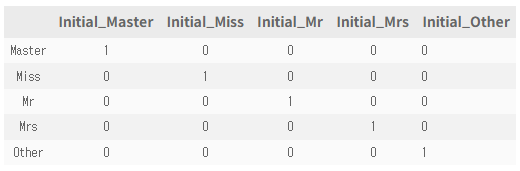

pandas 의 get_dummies 를 사용하여 쉽게 해결 가능

총 5개의 카테고리는 one-hot encoding 을 하고 나면 새로운 5개의 column 이 생김

initial 을 prefix 로 두어서 구분이 쉽게 만들어 줌

In [ ]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [ ]:
df_train.head()

one-hot encoded columns 가 생성됨

In [ ]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

In [ ]:
# 사용하지 않는 column drop
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name',  'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [ ]:
df_train.head()

In [ ]:
df_test.head()

survived feature 빼고는 train 과 test 가 같은 columns 를 가짐

**4.1 Model development - Machine learningl(Randomforest)**

In [ ]:
#importing all the required ML packages
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics # 모델의 평가를 위해 사용
from sklearn.model_selection import train_test_split # traning set을 쉽게 나눠주는 함수

In [ ]:
# 학습에 쓰일 데이터와 survived 를 분리 (by drop())
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

In [ ]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)

In [ ]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

In [ ]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

**4.2 Machine Learning Prediction - Feature Importance**

학습된 모델은 feature importance 를 가지게 됨

이것을 통해 지금 만든 모델이 어떤 feature 에 영향을 많이 받았는지 확인할 수 있음

In [ ]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

In [ ]:
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

**4.3 Prediction on Test set**

In [ ]:
submission = pd.read_csv('../input/titanic/gender_submission.csv')

In [ ]:
submission.head()

In [ ]:
# testset 에 대하여 예측, 결과를 csv 파일로 저장
prediction = model.predict(X_test)
submission['Survived'] = prediction

In [ ]:
submission.to_csv('./titanic_submission.csv', index=False)